In [11]:
import os
import pandas as pd

import mar
import preprocessing

In [ ]:
pat_num = 4

In [13]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

In [14]:
mar_data = preprocessing.load_mar_data(data_dir, pat_num)
sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
accel_data = preprocessing.load_accel_data(data_dir, pat_num)
# ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

In [15]:
mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

for mar_class in mar_classes:
    print(mar_class + " : " + str(mar_classes[mar_class].shape))

narcotics : (414, 4)
paralytics : (0, 4)
alpha_agonists : (44, 4)
ketamines : (9, 4)
propofols : (41, 4)
etomidates : (0, 4)
benzodiazepines : (290, 4)


In [16]:
drug_doses = {}
drug_concentrations = {}

for mar_class in mar_classes:
    if mar_classes[mar_class].shape[0] < 1:
        continue

    for drug_name in mar.classes()[mar_class]:
        drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
        
        if drug_df.shape[0] < 1:
            continue

        print(drug_name + " : " + str(drug_df.shape))

        drug_doses[drug_name] = mar.calculate_doses(drug_df)
        drug_concentrations[drug_name] = mar.calculate_concentrations_rk4(drug_doses[drug_name], elimination_rate=mar.elimination_rates()[drug_name])

print("")

for drug_name in drug_doses:
    print(drug_name + " : " + str(drug_doses[drug_name].shape))

fentanyl : (76, 4)
morphine : (151, 4)
hydromorphone : (144, 4)
methadone : (43, 4)
dexmedetomidine : (39, 4)
clonidine : (5, 4)
ketamine : (9, 4)
propofol : (41, 4)
midazolam : (253, 4)
diazepam : (37, 4)

fentanyl : (2429, 4)
morphine : (6888, 4)
hydromorphone : (5162, 4)
methadone : (22162, 4)
dexmedetomidine : (1711, 4)
clonidine : (1409, 4)
ketamine : (7791, 4)
propofol : (15473, 4)
midazolam : (14374, 4)
diazepam : (14549, 4)


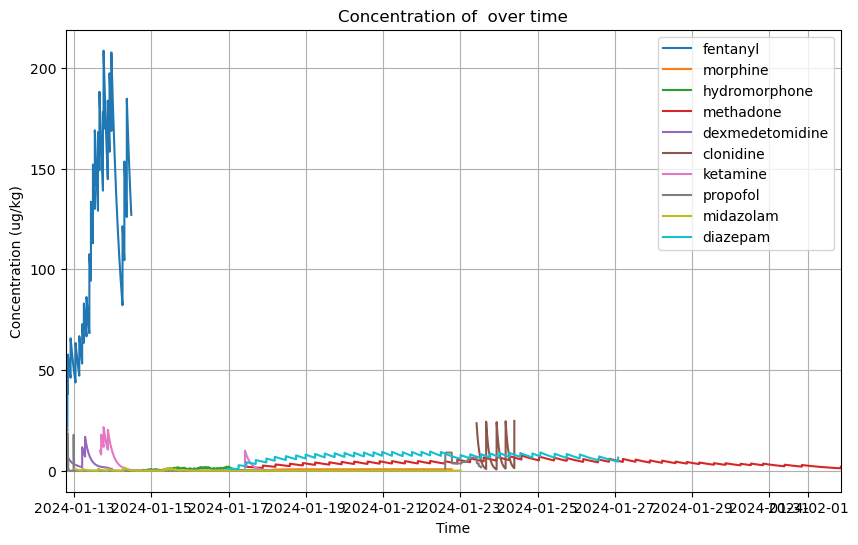

In [17]:
for drug_name in drug_concentrations:
    mar.plot_concentration(drug_concentrations, drug_name, show=False, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug_name}_concentration.png'))

mar.plot_concentration(drug_concentrations, 'all', show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_all_concentration.png'))

In [18]:
metrics = {
    'heart_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'heart_rate': sickbay_data['heart_rate']
    }),
    'respiratory_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'respiratory_rate': sickbay_data['respiratory_rate']
    }),
    'acceleration': pd.DataFrame({
        'time': accel_data['time'],
        'acceleration': accel_data['a']
    }),
}

In [19]:
windows = [2, 60, 3600]

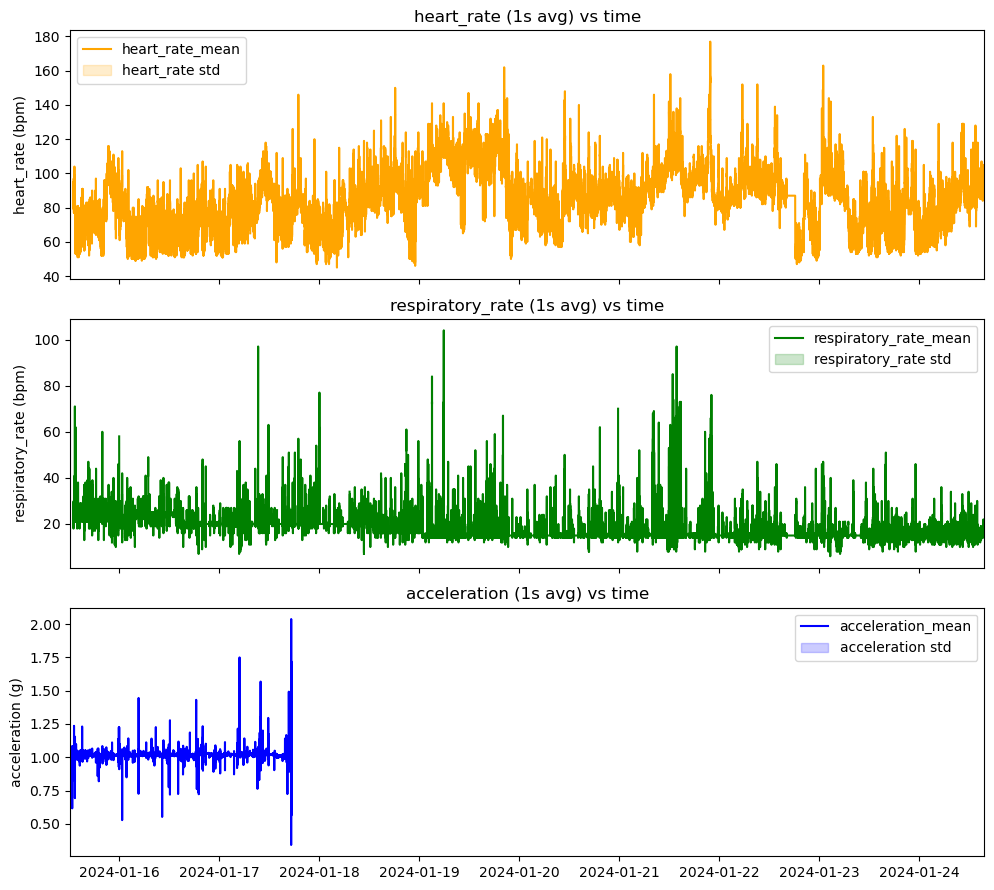

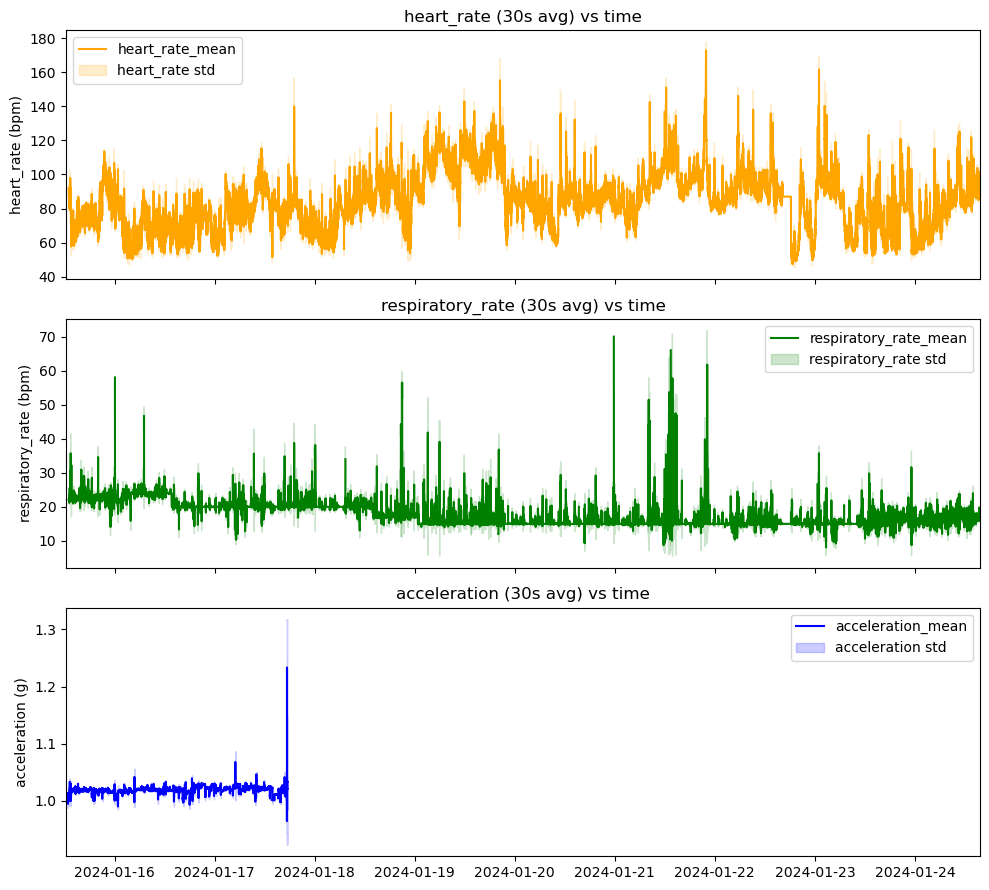

In [ ]:
for window in windows:
    mar.plot_metrics(metrics, window=window, std=True, show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_metrics_{window}s.png'))